['GRBALPHA_20241017T082528_pickled.bin', 'GRBALPHA_20241017T224535_pickled.bin', 'GRBALPHA_20241018T001903_pickled.bin', 'GRBALPHA_20241018T110034_pickled.bin', 'GRBALPHA_20241018T221326_pickled.bin', 'GRBALPHA_20241018T234627_pickled.bin', 'GRBALPHA_20241019T085324_pickled.bin', 'GRBALPHA_20241019T102657_pickled.bin', 'GRBALPHA_20241019T214126_pickled.bin', 'GRBALPHA_20241020T224123_pickled.bin', 'GRBALPHA_20241022T230911_pickled.bin', 'GRBALPHA_20241023T094901_pickled.bin', 'GRBALPHA_20241024T105037_pickled.bin', 'GRBALPHA_20241025T230331_pickled.bin', 'GRBALPHA_20241026T223029_pickled.bin', 'GRBALPHA_20241027T000340_pickled.bin', 'GRBALPHA_20241027T233012_pickled.bin', 'GRBALPHA_20241028T083709_pickled.bin', 'GRBALPHA_20241028T100958_pickled.bin', 'GRBALPHA_20241028T225645_pickled.bin', 'GRBALPHA_20241029T003018_pickled.bin', 'GRBALPHA_20241030T090242_pickled.bin', 'GRBALPHA_20241030T103630_pickled.bin', 'GRBALPHA_20241030T232232_pickled.bin', 'GRBALPHA_20241031T005632_pickled.bin',

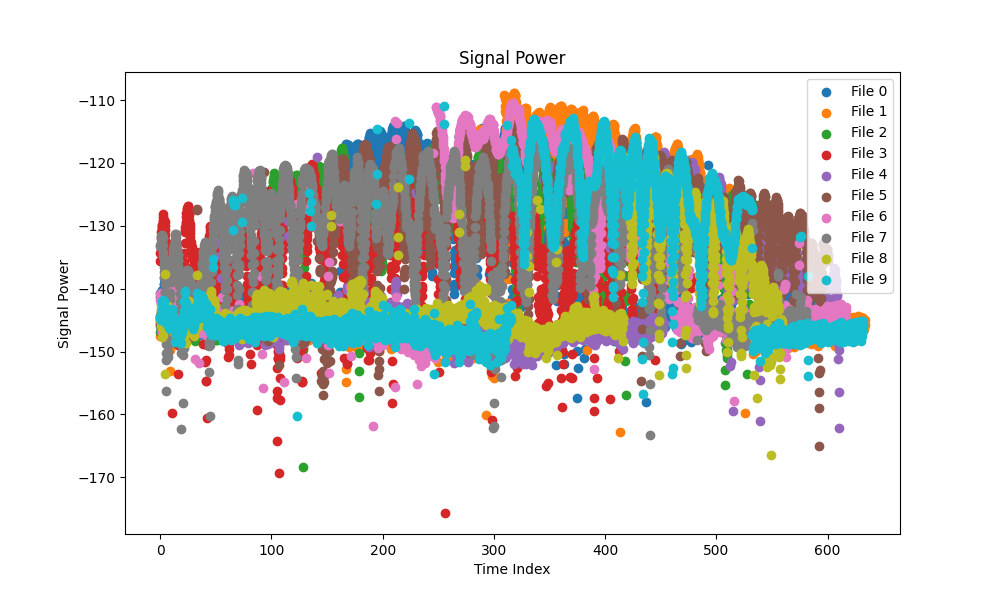

In [1]:
%matplotlib widget
#remember to pip install ipympl
import matplotlib.pyplot as plt
import noisy_moose as nm  # Ensure noisy_moose is installed
import json
import pickle
import numpy as np
import os


# Define the data path
data_path = 'C:/Users/StoreElberg/OneDrive - Aalborg Universitet/Git3/no_waterfall/active/'

# Get all files in the directory
files = os.listdir(data_path)

# Filter files starting with 'GRBALPHA'
files = [f for f in files if f.startswith('GRBALPHA')]

# Print the filtered files
print(files)

def calculate_pointing_error(set_azimuth, set_elevation, azimuth, elevation):
    """
    Calculate the pointing error given reference (set) and measured azimuth and elevation.
    
    Parameters:
        set_azimuth (array-like): Reference azimuth values in degrees.
        set_elevation (array-like): Reference elevation values in degrees.
        azimuth (array-like): Measured azimuth values in degrees.
        elevation (array-like): Measured elevation values in degrees.
    
    Returns:
        np.ndarray: Pointing error for each pair of reference and measured angles in degrees.
    """
    # Convert degrees to radians
    set_azimuth_rad = np.radians(set_azimuth)
    set_elevation_rad = np.radians(set_elevation)
    azimuth_rad = np.radians(azimuth)
    elevation_rad = np.radians(elevation)
    
    # Compute the pointing error using the great-circle distance formula
    pointing_error_rad = np.arccos(
        np.sin(set_elevation_rad) * np.sin(elevation_rad) +
        np.cos(set_elevation_rad) * np.cos(elevation_rad) * np.cos(azimuth_rad - set_azimuth_rad)
    )
    
    # Convert the pointing error back to degrees
    pointing_error_deg = np.degrees(pointing_error_rad)
    return pointing_error_deg

def unpickle(file):
    """Unpickles the given file from data_path."""
    try:
        with open(data_path + file, 'rb') as f:
            dump = f.read()
        return pickle.loads(dump)
    except FileNotFoundError:
        print(f"File {file + '_pickled.bin'} not found. Skipping.")
        return None

def extract_features(prop_obj):
    """Extract multiple features from the given object."""
    if prop_obj is None:
        return None  # Skip if object is None

    # Calculate features
    pointing_error = calculate_pointing_error(
        prop_obj.station_obj.set_azimuth, 
        prop_obj.station_obj.set_elevation, 
        prop_obj.station_obj.azimuth, 
        prop_obj.station_obj.elevation
    )
    corrected_power = 10 * np.log10(prop_obj.noise_obj.signal_abs) - prop_obj.station_obj.fspl

    # Features
    features = [
        prop_obj.time_ax,                  # Time (0)
        prop_obj.noise_obj.signal_abs,     # Signal Power (1)
        prop_obj.station_obj.fspl,         # FSPL (2)
        prop_obj.station_obj.dist,         # Distance (3)
        prop_obj.station_obj.set_azimuth,  # Target azimuth (4)
        prop_obj.station_obj.set_elevation,# Target elevation (5)
        pointing_error,                    # Pointing error (6)
        prop_obj.noise_obj.noise,          # Noise power in W/Hz (7)
        corrected_power,                   # FSPL corrected signal power (8)
    ]

    # Find the maximum length
    max_length = max(len(feature) for feature in features)

    # Pad all features to the maximum length
    padded_features = [
        np.pad(feature, (0, max_length - len(feature)), constant_values=np.nan)
        for feature in features
    ]

    # Stack features column-wise
    return np.vstack(padded_features)


# Collect and process data
data_list = []
for f in files[:30]:  # Go through all files
    data: nm.prepping = unpickle(f)
    if data is not None:
        features = extract_features(data)
        if features is not None:
            data_list.append(features)

# Determine maximum length for padding
max_length = max(features.shape[1] for features in data_list)

# Pad the data for each file
padded_data = [
    np.pad(features, ((0, 0), (0, max_length - features.shape[1])), constant_values=np.nan) #all the ones which are not long enough are padded with nan, not ZERO or interpolated.
    for features in data_list
]

# Convert to a 3D numpy array: (file index, feature index, time index)
BAM = np.array(padded_data, dtype=np.float32)
print(f"BAM shape: {BAM.shape} (files, features, time)")

# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

# Moving average Threshold
Choose this one or the normal threshold down under

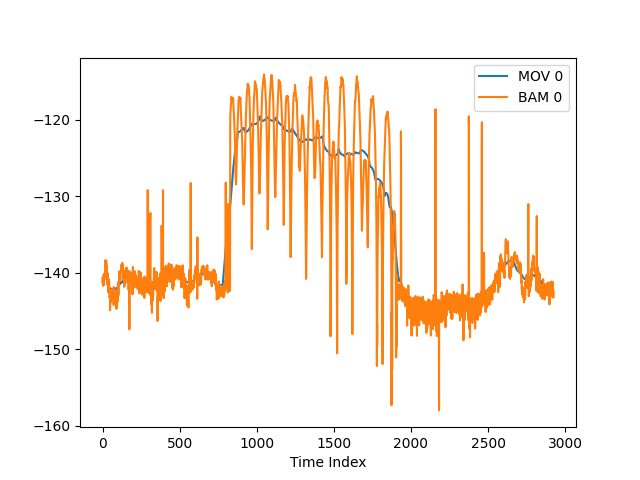

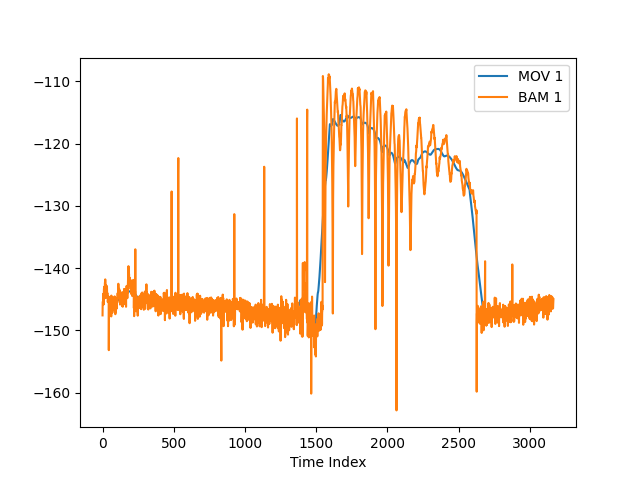

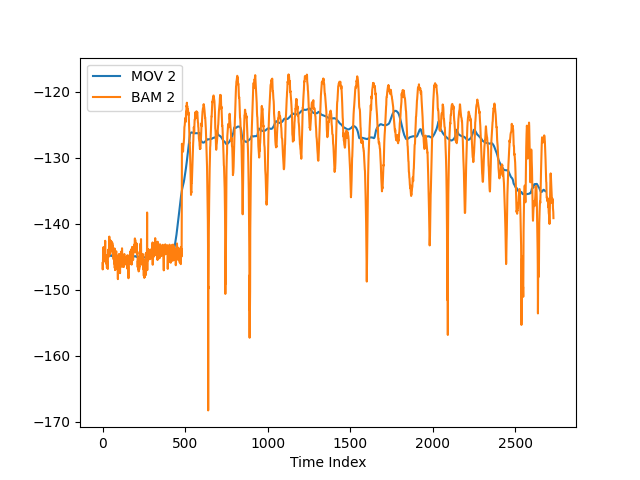

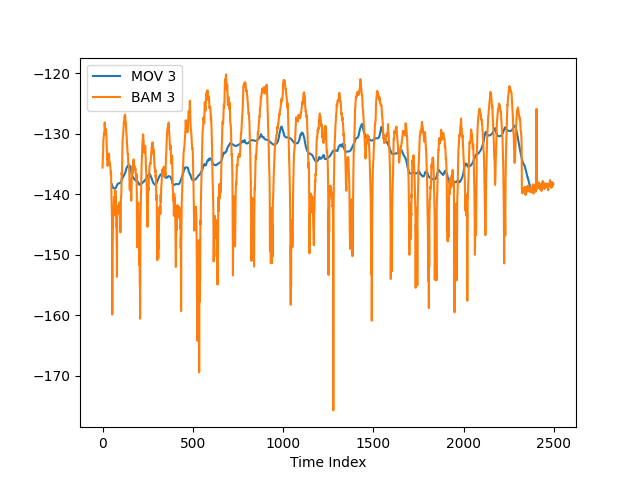

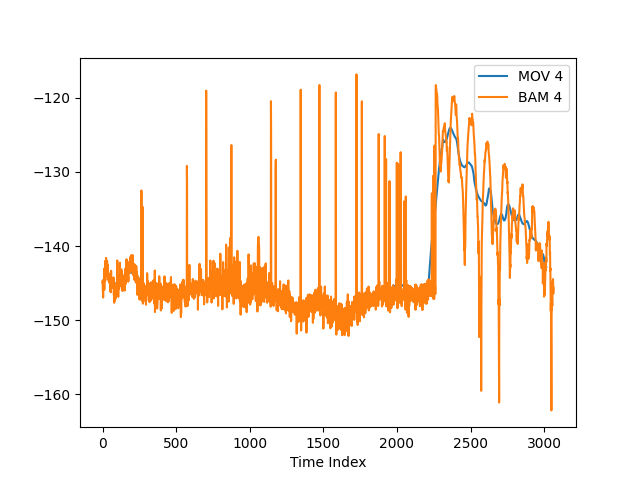

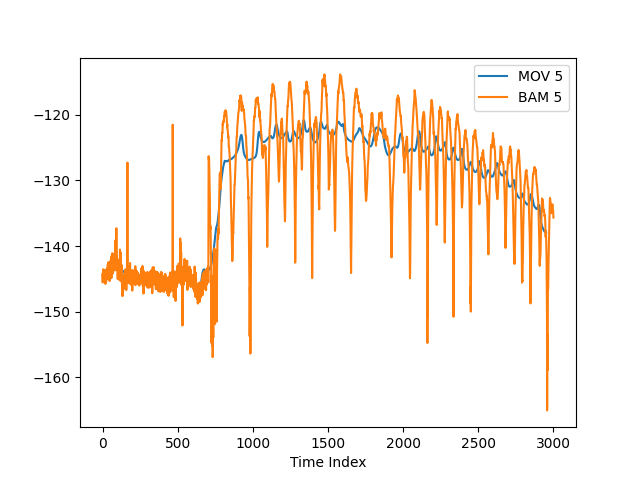

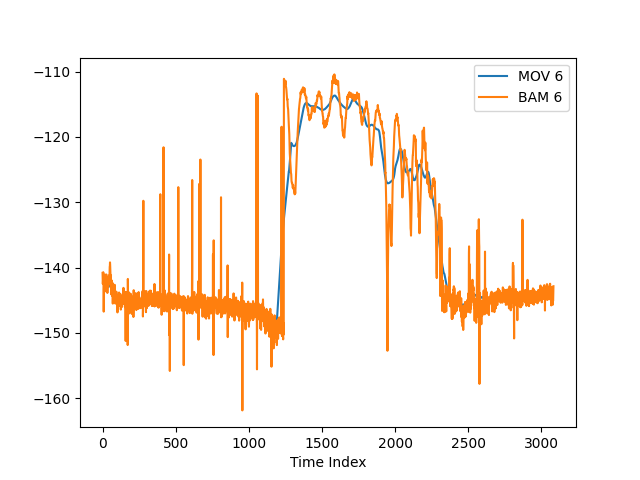

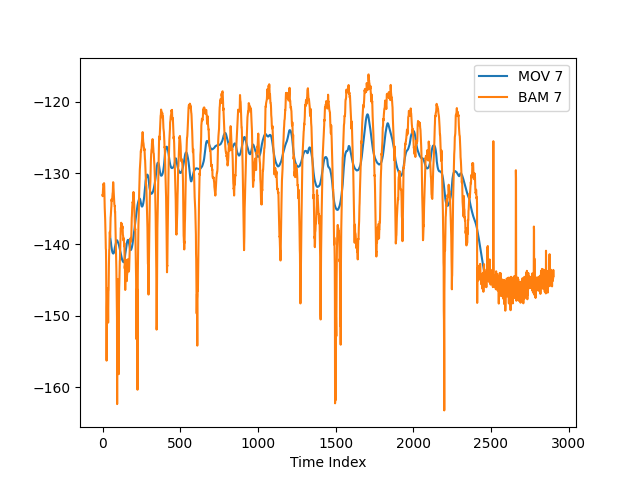

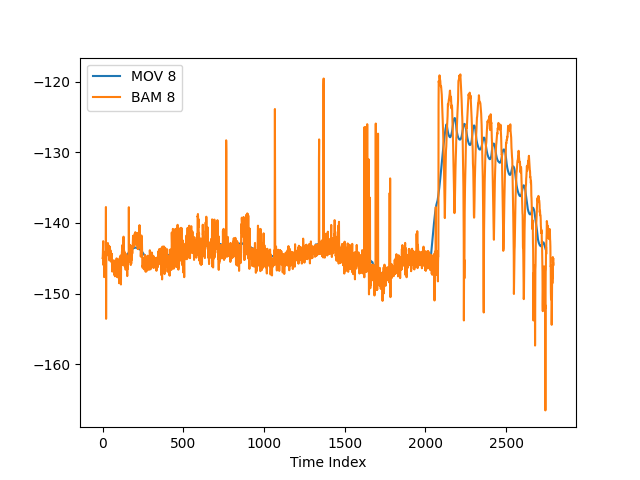

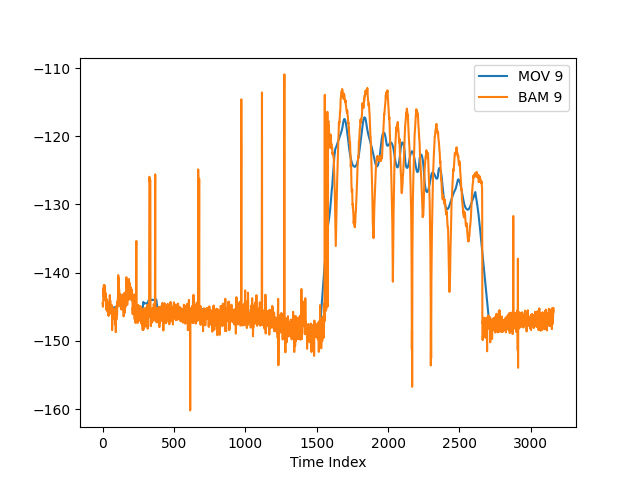

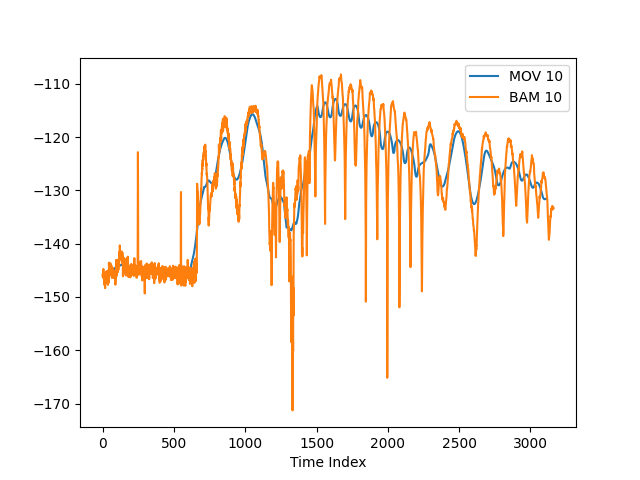

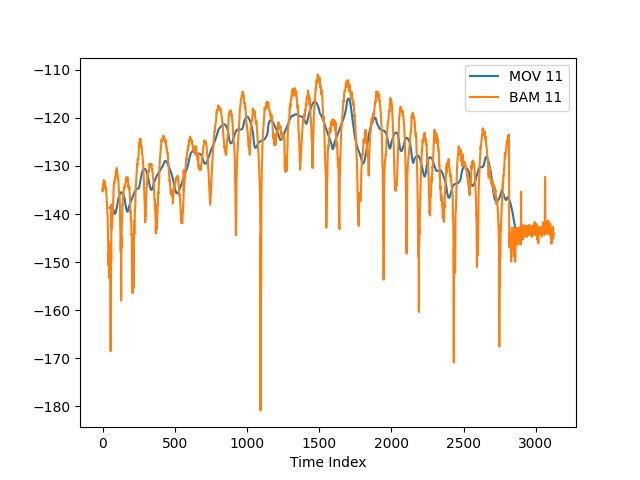

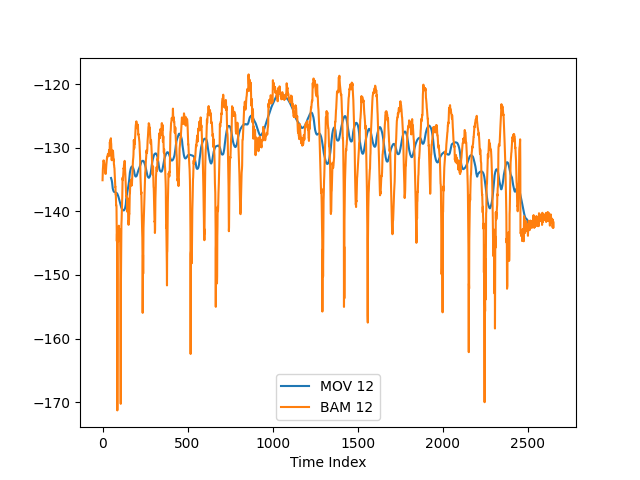

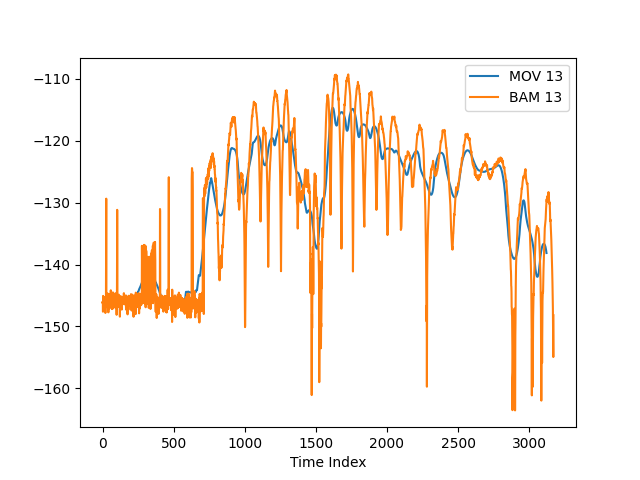

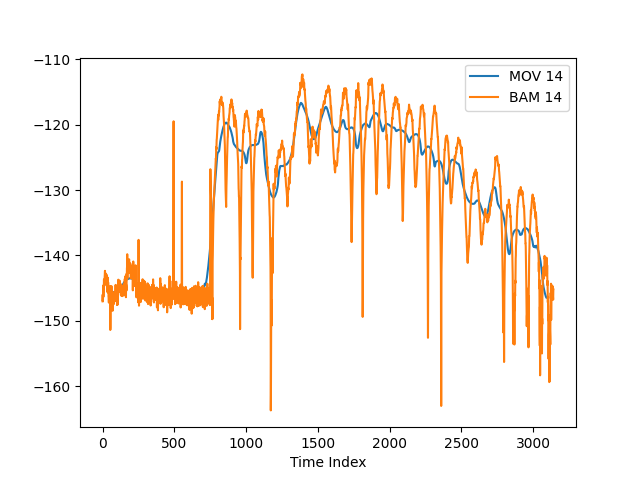

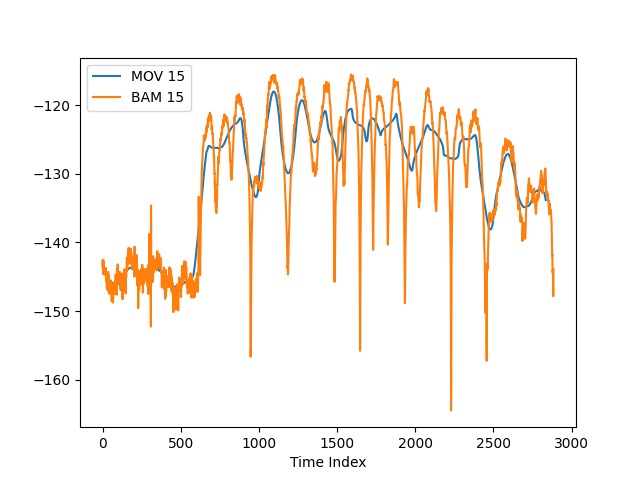

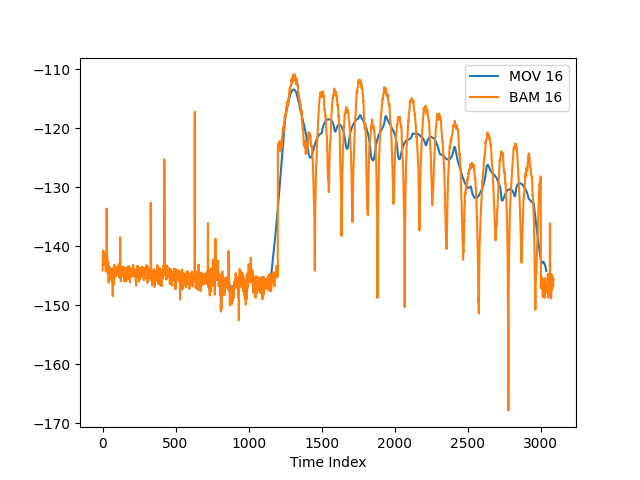

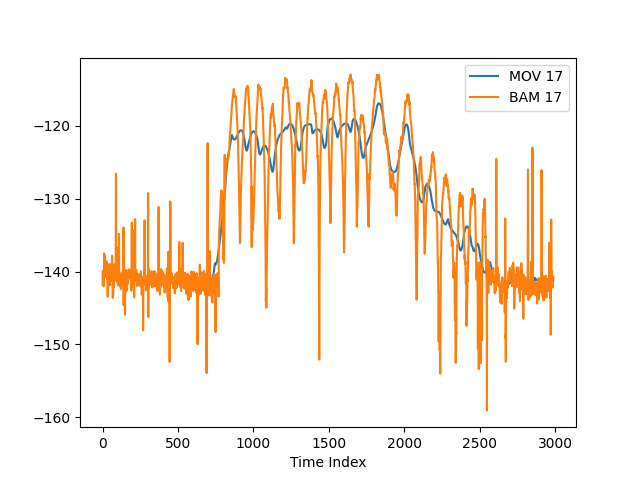

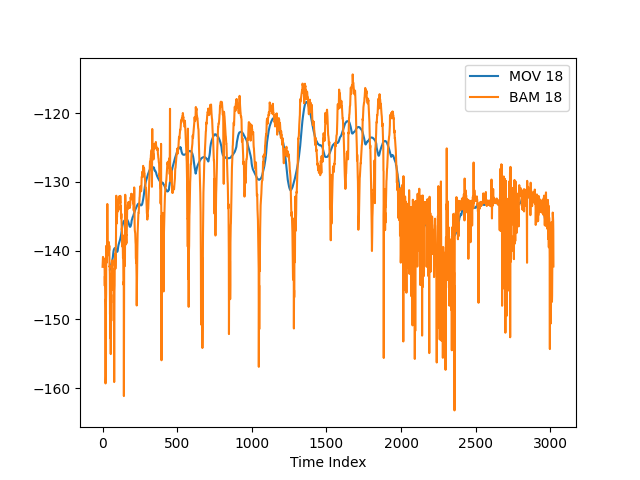

C:\Users\StoreElberg\AppData\Local\Temp\ipykernel_48856\3004987824.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


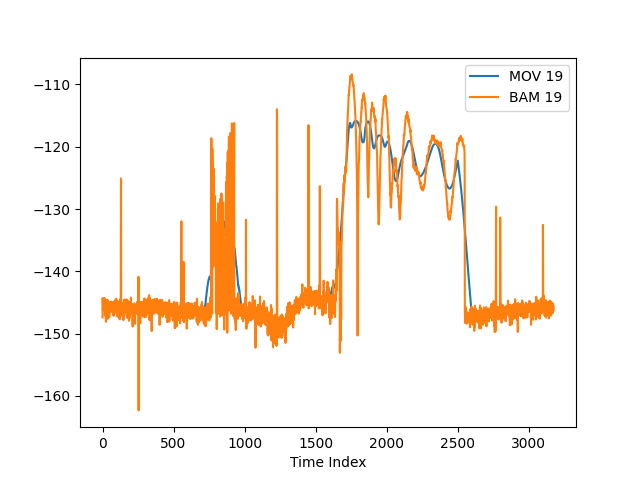

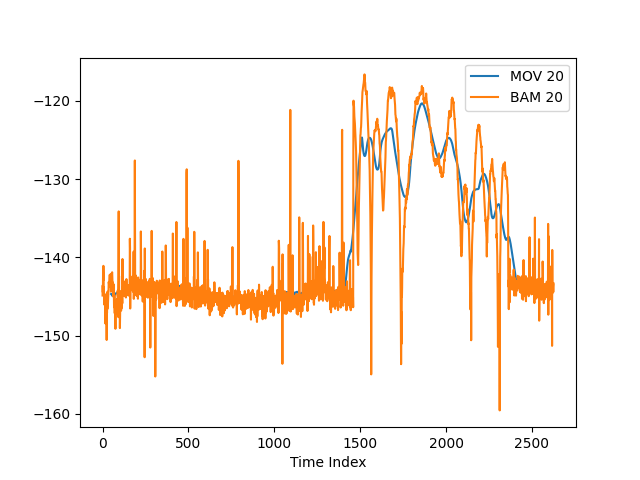

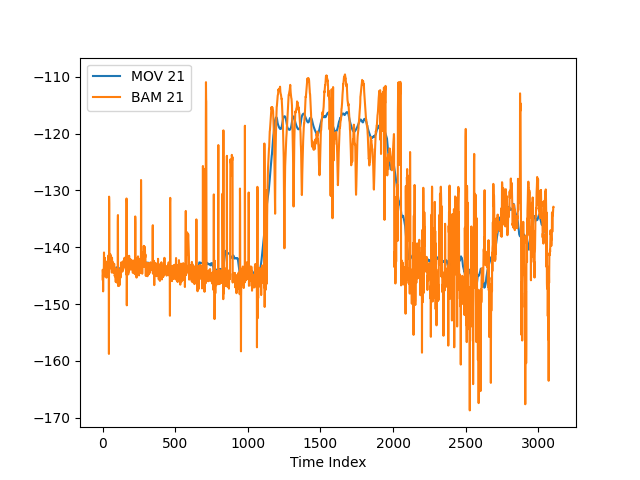

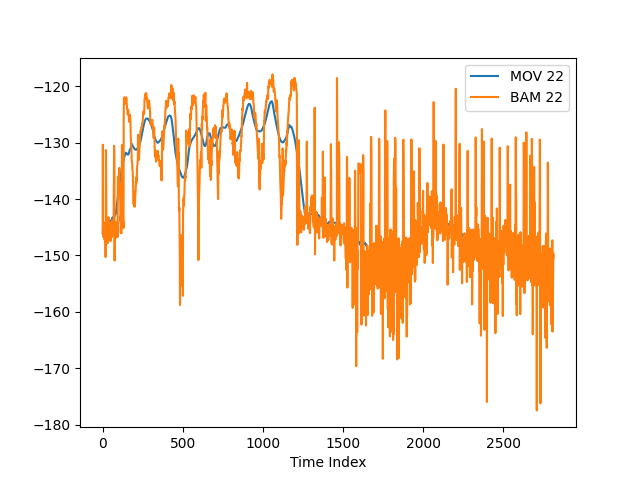

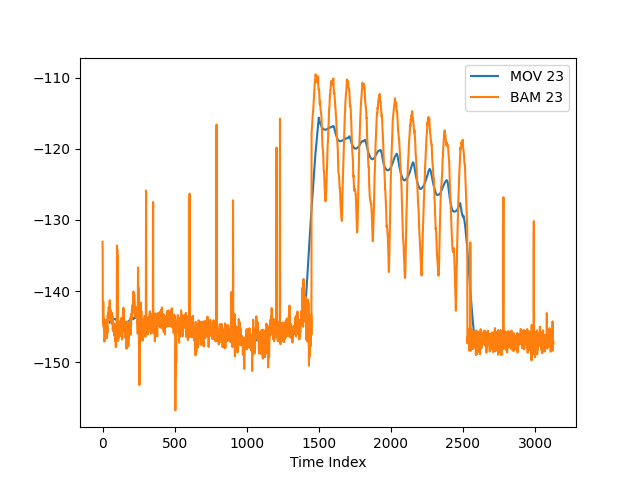

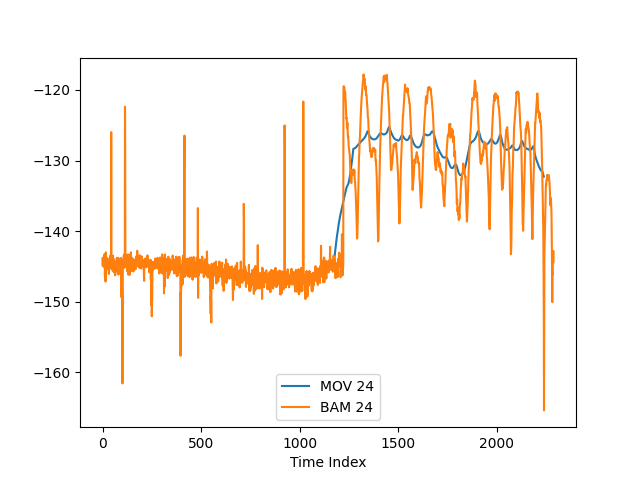

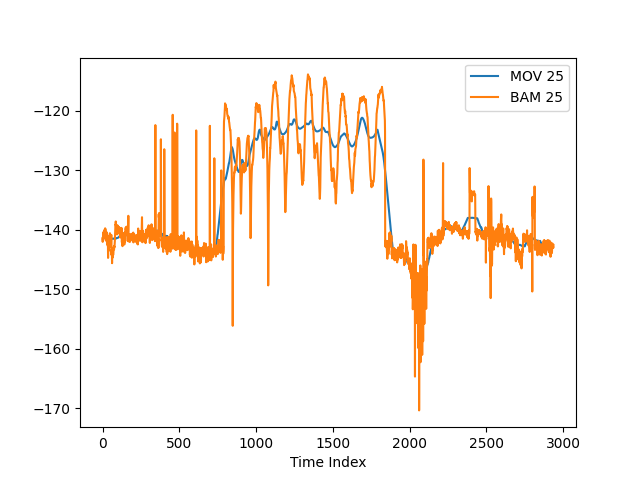

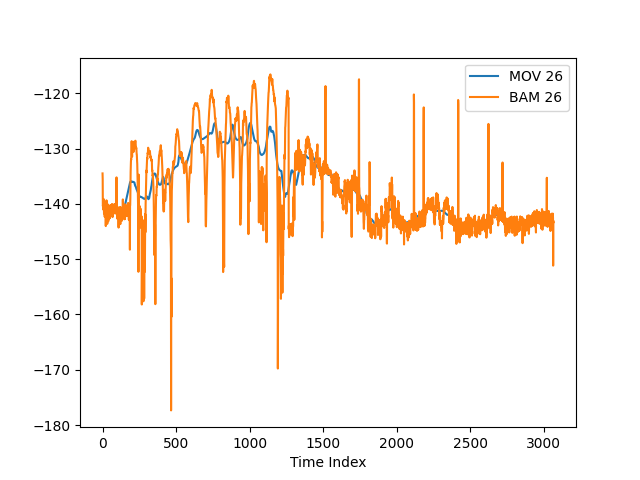

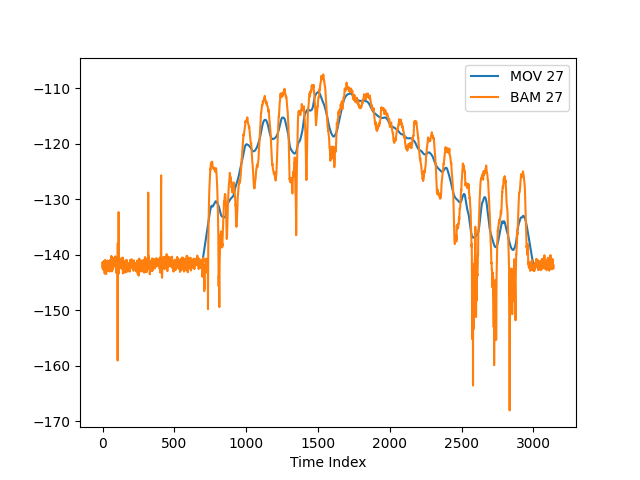

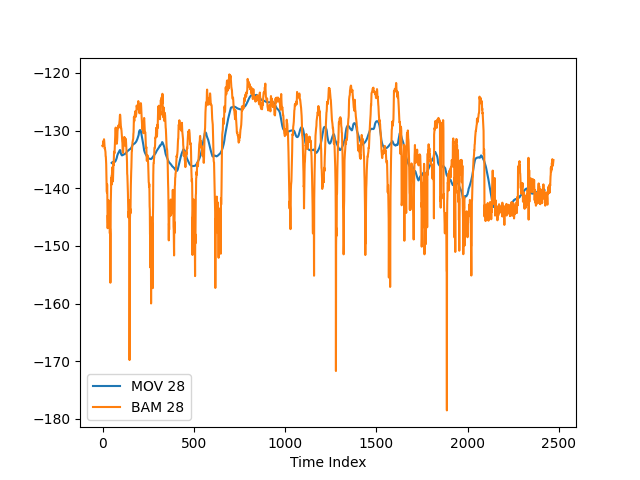

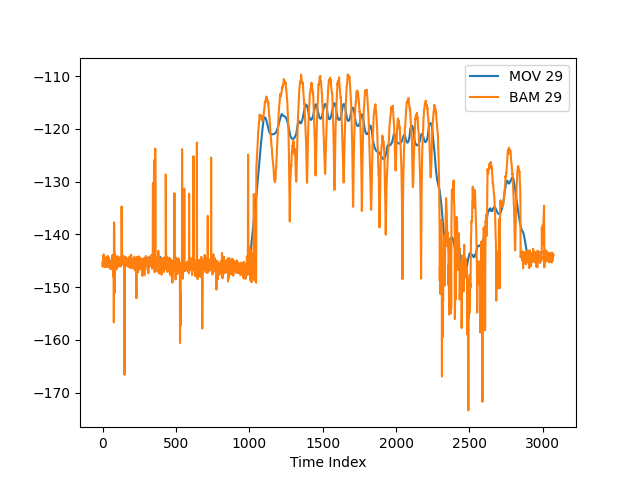

MOVBAM shape: (30, 3176)
BAM shape: 3176
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Mask shape: (30, 3176)
BAM shape: (30, 9, 3176)
Modified BAM with NaN applied based on the mask.


In [2]:
MOVBAM = []  # Initialize as an empty list
for i in range(BAM.shape[0]):
    # Compute moving average of the signal power
    # Define the moving average window size
    window_size = 100

    # Pad the signal symmetrically with NaNs (or a constant like -130 to match your data)
    padded_signal = np.pad(10 * np.log10(BAM[i, 1, :]), (50, 49), mode='constant', constant_values=np.nan)

    # Perform convolution in 'valid' mode
    moving_avg = np.convolve(padded_signal, np.ones(window_size)/window_size, mode='valid')

    # moving_avg = np.convolve(10*np.log10(BAM[i, 1, :]), np.ones(100)/100, mode='valid')
    # moving_avg = np.convolve(10*np.log10(BAM[i, 1, :]), np.ones(100)/100, mode='valid')
    MOVBAM.append(moving_avg)  # Append the result to the list
    plt.figure()
    plt.plot(moving_avg, label=f'MOV {i}')
    plt.plot(10*np.log10(BAM[i, 1, :]), label=f'BAM {i}')
    plt.xlabel('Time Index')
    plt.legend()
    plt.show()


# Convert MOVBAM to a numpy array for easier manipulation
MOVBAM = np.array(MOVBAM)

# Print the shape of MOVBAM
print(f"MOVBAM shape: {MOVBAM.shape}")
print(f"BAM shape: {BAM.shape[2]}")

print(MOVBAM)
# mask = MOVBAM[:,:] < 10**(-138/10)
mask = MOVBAM[:,:] < -140
print(mask)
# Add a new column to BAM based on the mask
new_column = np.where(mask, np.nan, 1)  # Set to NaN where mask is True, otherwise 1
# Pad the mask to the length of BAM.shape[2] with False values
padded_mask = np.pad(mask, ((0, 0), (0, BAM.shape[2] - mask.shape[1])), constant_values=True)

# Check the shape of the mask
print(f"Mask shape: {padded_mask.shape}")
print(f"BAM shape: {BAM.shape}")

# Expand the mask to match BAM dimensions (broadcast over the features dimension)
expanded_mask = np.expand_dims(padded_mask, axis=1)  # Shape becomes [file, 1, index]
expanded_mask = np.repeat(expanded_mask, BAM.shape[1], axis=1)  # Repeat over features dimension

# Set all points in BAM to NaN where the mask is True
BAM[expanded_mask] = np.nan

# Print confirmation
print(f"Modified BAM with NaN applied based on the mask.")

# Threshold

In [5]:
threshold=10**(-138/10) #-138dBm
print(threshold)
for file_idx in range(BAM.shape[0]):
    signal_power = BAM[file_idx, 1, :]  # Signal power is at feature index 1

    # Identify time indices where signal power is below the threshold
    mask = signal_power < threshold

    # Set all features at these time indices to NaN for the current file
    BAM[file_idx, :, mask] = np.nan

1.584893192461111e-14


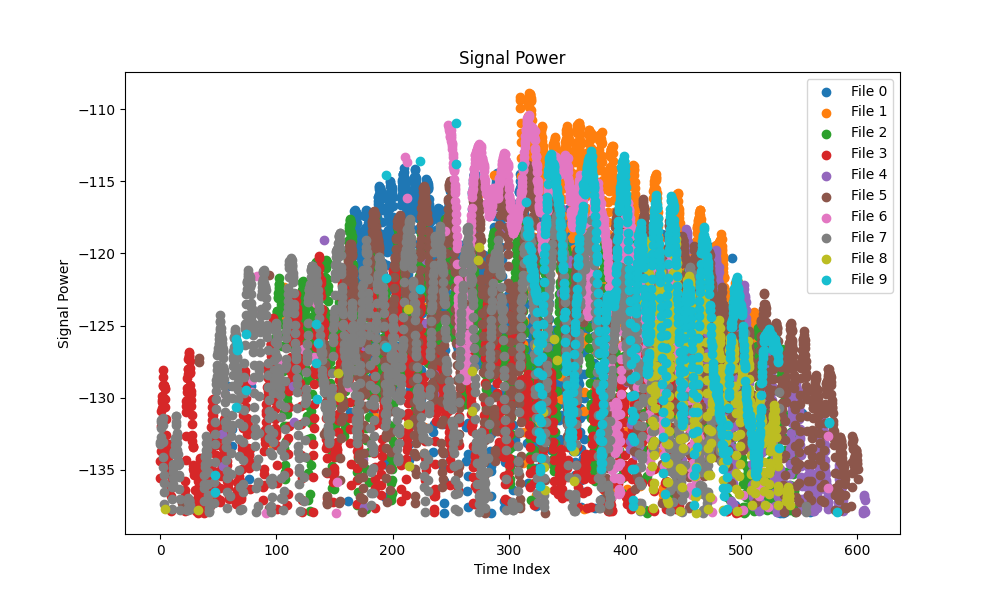

In [6]:
# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()